In [1]:
from fenics import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
from egfcore import *
from utils import *

set_log_level(30)
%matplotlib widget

In [2]:
class Simulator:
    
    def __init__(self, meshDensity):
        self.mesh = IntervalMesh(meshDensity,0,1) # (meshDensity = N_sensors) =  # of positions at which the problem is discretized on a unit interval
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh.mat", mesh_dict)
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        # Define the function space and store the meshweights for computation.
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh2D.mat", mesh_dict)
        
        # Create variational form for the problem
        self.bc = self.boundaryConditions()
        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        self.f = Function(V)
        self.param = Constant(0)
        self.d2v = dof_to_vertex_map(V)
        self.a = dot(grad(u), grad(v))* dx
        self.L = self.f*v*dx
        self.u = Function(self.V)
        
    def boundaryConditions(self):
        """
        Define homogeneous Dirichlet Boundary conditions for the problem.
        """
        def boundary(x, on_boundary):
            return on_boundary
        
        u_D = Constant(0)
        bc = DirichletBC(self.V, u_D, boundary)
        
        return bc
    
    def solve(self, forcing, noise_level = None, param=None):
        """
        Given a (N_sensors x 1) forcing vector, solve the a 1D Poisson problem on a unit interval.
        """
        
        self.f.vector()[:] = forcing[self.d2v] # Instantiate the source term in the variational form by interpolating the sampled sourcing term.
        if param is not None:
            self.param.assign(param) # Define the parameter for the problem
        solve(self.a == self.L, self.u, self.bc) # Solve the variation form

        # Sample the solution at the nodes of the mesh.
        solution = self.u.compute_vertex_values(self.mesh)
        
        # As specified, add IID Gaussian white noise.
        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise
        
        return solution

In [3]:
def exactGreen(domain, param):
    x, s = np.meshgrid(domain,domain)
    G = np.empty(np.shape(x))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            xx, ss = x[i,j], s[i,j]
            if xx <= ss:
                G[i,j] = xx * (1-ss)
            else:
                G[i,j] = ss * (1-xx)
    return G

In [8]:
%%time
add_noise = False
noise_level = 0.1
params = np.array([0])
verbose = False

# np.random.seed(42)


meshDensitySpace = np.array([2000]) #np.linspace(50, 500, 9)
# meshDensitySpace = np.array([200]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([0.0025])  # np.logspace(-2, -1, 10) 
nSamplesSpace = np.array([100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

runs = 10
errors = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]))
models = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]), dtype = 'O')

for run in range(runs):
    print(f"Run {run}:")
    for i, meshDensity in enumerate(meshDensitySpace):
        for j, sigma in enumerate(sigmaSpace):
            Forcing = sampleforcing(sigma, nSamplesSpace[-1], np.random.randint(1,1000));
            for k, nSamples in enumerate(nSamplesSpace):
                for l, rank in enumerate(rankSpace):
                    print(f"Method: Coefficient fit | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")
                    Sim = Simulator(meshDensity)
                    forcing = Forcing[:,:nSamples]
                    print(forcing.shape)
                    solution = np.zeros(forcing.shape)
                    for s in range(solution.shape[1]):
                        if verbose:
                            print("i = %d / %d"%(s+1, solution.shape[1]))
                        if add_noise:
                            solution[:,s] = Sim.solve(forcing[:,s], noise_level)
                        else:
                            solution[:,s] = Sim.solve(forcing[:,s])
                    models[run, i,j,k,l] = EGF("coefficient-fit", params, rank, Sim.mesh, forcing, solution, None, None, None, None, verbose = verbose)

                    G_reconstruction = reconstructEGF1D(models[run, i,j,k,l])
                    G = exactGreen(models[run, i,j,k,l].mesh.coordinates(), models[run, i,j,k,l].params[0])
                    errors[run, i,j,k,l] = errorL2(G_reconstruction, G, models[run, i,j,k,l].meshweights)

Run 0:
> In chebfun2/constructor (line 121)
In chebfun2 (line 82)
In sample1D (line 13)
In run (line 91) 
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 100, rank: 100, Noise: False
(2001, 100)
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 250, rank: 100, Noise: False
(2001, 250)
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 500, rank: 100, Noise: False
(2001, 500)
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 750, rank: 100, Noise: False
(2001, 750)
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 1000, rank: 100, Noise: False
(2001, 1000)
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 1250, rank: 100, Noise: False
(2001, 1250)
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 1500, rank: 100, Noise: False
(2001, 1500)
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 1750, rank: 100, Noise: False
(2001, 1750

In [5]:
import matplotlib.ticker as mticker

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

In [10]:
errorsamples = np.hstack([nSamplesSpace.reshape((-1,1)), np.mean(errors, axis = 0)[0,0,:,0].reshape((-1,1))])
np.savetxt('errorsamples.csv', errorsamples, delimiter=',') 

Text(0.0, 1.0, 'A')

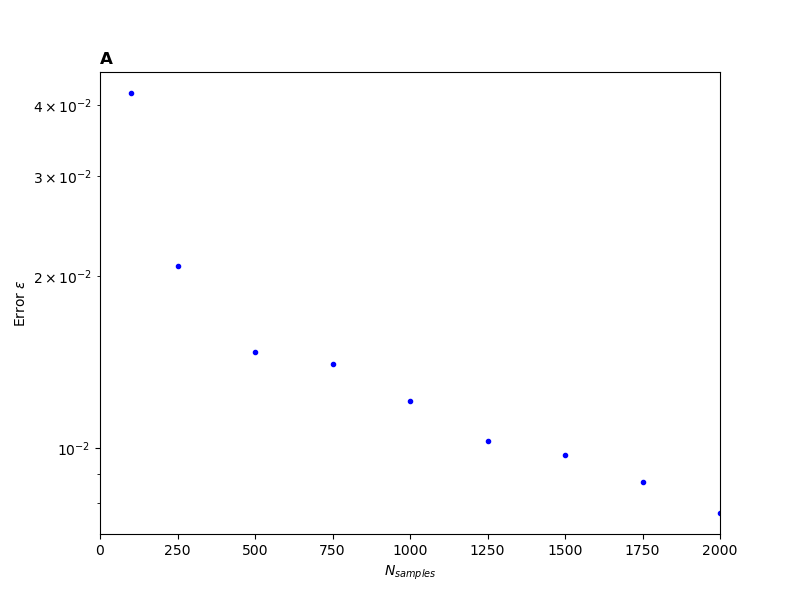

In [11]:
meshDensitySpace = np.array([2000]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([0.0025])  # np.logspace(-2, -1, 10) 
nSamplesSpace = np.array([100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

plt.figure(figsize = (8,6))
plt.semilogy(nSamplesSpace,np.mean(errors, axis = 0)[0,0,:,0],'b.')
plt.xlabel('$N_{samples}$')
plt.ylabel('Error $\epsilon$')
plt.xlim([0,2000])
plt.title('A',loc ='left', weight = 'bold', size = 12)

In [15]:
%%time
add_noise = False
noise_level = 0.1
params = np.array([0])
verbose = False

np.random.seed(42)

runs = 10
meshDensitySpace = np.array([2000]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([1, 0.5, 0.3, 0.2, 0.1, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025])  # np.logspace(-2, -1, 10)
nSamplesSpace = np.array([2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

errors2 = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]))
models2 = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]), dtype = 'O')

for run in range(runs):
    print(f"Run {run}:")
    for i, meshDensity in enumerate(meshDensitySpace):
        for j, sigma in enumerate(sigmaSpace):
            seed = np.random.randint(1,1000)
            for k, nSamples in enumerate(nSamplesSpace):
                for l, rank in enumerate(rankSpace):
                    print(f"Method: Coefficient fit | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")
                    Sim = Simulator(meshDensity)
                    forcing = sampleforcing(sigma, nSamples, seed)
                    solution = np.zeros(forcing.shape)
                    for s in range(solution.shape[1]):
                        if verbose:
                            print("i = %d / %d"%(s+1, solution.shape[1]))
                        if add_noise:
                            solution[:,s] = Sim.solve(forcing[:,s], noise_level)
                        else:
                            solution[:,s] = Sim.solve(forcing[:,s])
                    models2[run, i,j,k,l] = EGF("coefficient-fit", params, rank, Sim.mesh, forcing, solution, None, None, None, None, verbose = verbose)

                    G_reconstruction = reconstructEGF1D(models2[run, i,j,k,l])
                    G = exactGreen(models2[run, i,j,k,l].mesh.coordinates(), models2[run, i,j,k,l].params[0])
                    errors2[run, i,j,k,l] = errorL2(G_reconstruction, G, models2[run, i,j,k,l].meshweights)

Run 0:
Method: Coefficient fit | meshDensity: 2000, sigma: 1.0, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.5, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.3, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.2, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.1, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.05, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.025, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.01, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0075, nSamples: 2000, rank: 100, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.005, nSamples: 2000, rank: 100, Noise: False
Method: Coeffi

In [16]:
errorsigma = np.hstack([sigmaSpace.reshape((-1,1)), np.mean(errors2, axis = 0)[0,:,0,0].reshape((-1,1))])
np.savetxt('errorsigma.csv', errorsigma, delimiter=',') 

Text(0.0, 1.0, 'B')

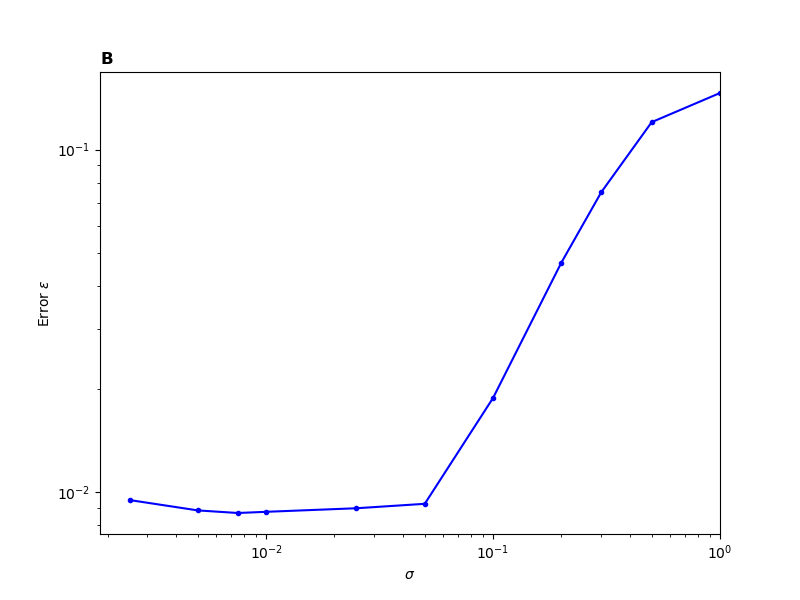

In [19]:
meshDensitySpace = np.array([2000]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([1, 0.5, 0.3, 0.2, 0.1, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025])  # np.logspace(-2, -1, 10) 
nSamplesSpace = np.array([2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

plt.figure(figsize = (8,6))
plt.loglog(sigmaSpace,np.mean(errors2, axis = 0)[0,:,0,0],'b.-')
plt.xlabel('$\\sigma$')
plt.ylabel('Error $\epsilon$')
plt.xlim(right = 1)
plt.title('B',loc ='left', weight = 'bold', size = 12)

In [20]:
%%time
add_noise = False
noise_level = 0.1
params = np.array([0])
verbose = False

np.random.seed(42)

runs = 10
meshDensitySpace = np.array([2000]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([0.0025])  # np.logspace(-2, -1, 10) 
nSamplesSpace = np.array([2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([10, 11, 12, 13, 15, 18, 25, 50, 75, 100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

errors3 = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]))
models3 = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]), dtype = 'O')

for run in range(runs):
    print(f'\nRun {run}:')
    for i, meshDensity in enumerate(meshDensitySpace):
        for j, sigma in enumerate(sigmaSpace):
            for k, nSamples in enumerate(nSamplesSpace):
                Sim = Simulator(meshDensity)
                forcing = sampleforcing(sigma, nSamples, np.random.randint(1,1000))
                solution = np.zeros(forcing.shape)
                for s in range(solution.shape[1]):
                    if verbose:
                        print("i = %d / %d"%(s+1, solution.shape[1]))
                    if add_noise:
                        solution[:,s] = Sim.solve(forcing[:,s], noise_level)
                    else:
                        solution[:,s] = Sim.solve(forcing[:,s])
                for l, rank in enumerate(rankSpace):
                    print(f"Method: Coefficient fit | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")
                    
                    models3[run, i,j,k,l] = EGF("coefficient-fit", params, rank, Sim.mesh, forcing, solution, None, None, None, None, verbose = verbose)

                    G_reconstruction = reconstructEGF1D(models3[run, i,j,k,l])
                    G = exactGreen(models3[run, i,j,k,l].mesh.coordinates(), models3[run, i,j,k,l].params[0])
                    errors3[run, i,j,k,l] = errorL2(G_reconstruction, G, models3[run, i,j,k,l].meshweights)


Run 0:
> In chebfun2/constructor (line 121)
In chebfun2 (line 82)
In sample1D (line 13)
In run (line 91) 
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 10, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 11, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 12, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 13, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 15, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 18, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 25, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 50, Noise: False
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 75, Noise: False
Me

In [28]:
np.mean(errors3, axis = 0)[0,0,0,:]

array([0.01858819, 0.0167877 , 0.01538474, 0.01427669, 0.01266972,
       0.0111978 , 0.00968112, 0.00872979, 0.00862337, 0.00859684])

In [22]:
errorrank = np.hstack([rankSpace.reshape((-1,1)), np.mean(errors3, axis = 0)[0,0,0,:].reshape((-1,1))])
np.savetxt('errorrank.csv', errorrank, delimiter=',') 

Text(0.0, 1.0, 'C')

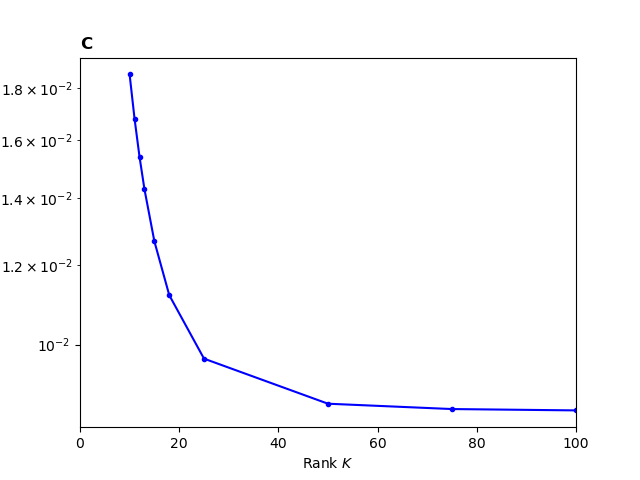

In [25]:
meshDensitySpace = np.array([2000]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([0.0025])  # np.logspace(-2, -1, 10) 
nSamplesSpace = np.array([2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([10, 11, 12, 13, 15, 18, 25, 50, 75, 100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

plt.figure()
plt.semilogy(rankSpace, np.mean(errors3, axis = 0)[0,0,0,:],'b.-')
plt.xlabel('Rank $K$')
plt.ylabel('$\epsilon$', rotation='horizontal', labelpad=15)
plt.xlim([0,100])
plt.title('C',loc ='left', weight = 'bold', size = 12)

In [27]:
%%time
add_noise = False
noise_level = 0.1
params = np.array([0])
verbose = False

# np.random.seed(42)


meshDensitySpace = np.array([2000, 4000, 8000, 16000]) #np.linspace(50, 500, 9)
# meshDensitySpace = np.array([200]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([0.0025])  # np.logspace(-2, -1, 10) 
nSamplesSpace = np.array([2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

runs = 10

errors4 = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]))
models4 = np.empty((runs, meshDensitySpace.shape[0], sigmaSpace.shape[0], nSamplesSpace.shape[0], rankSpace.shape[0]), dtype = 'O')

for run in range(runs):
    print(f"Run {run}:")
    seed = np.random.randint(1,1000)
    for i, meshDensity in enumerate(meshDensitySpace):
        for j, sigma in enumerate(sigmaSpace):
            for k, nSamples in enumerate(nSamplesSpace):
                for l, rank in enumerate(rankSpace):
                    print(f"Method: Coefficient fit | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")
                    Sim = Simulator(meshDensity)
                    forcing = sampleforcing(sigma, nSamples, seed)
                    solution = np.zeros(forcing.shape)
                    for s in range(solution.shape[1]):
                        if verbose:
                            print("i = %d / %d"%(s+1, solution.shape[1]))
                        if add_noise:
                            solution[:,s] = Sim.solve(forcing[:,s], noise_level)
                        else:
                            solution[:,s] = Sim.solve(forcing[:,s])
                    models4[run, i,j,k,l] = EGF("coefficient-fit", params, rank, Sim.mesh, forcing, solution, None, None, None, None, verbose = verbose)

                    G_reconstruction = reconstructEGF1D(models4[run, i,j,k,l])
                    G = exactGreen(models4[run, i,j,k,l].mesh.coordinates(), models4[run, i,j,k,l].params[0])
                    errors4[run, i,j,k,l] = errorL2(G_reconstruction, G, models4[run, i,j,k,l].meshweights)

Run 0:
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 100, Noise: False
> In chebfun2/constructor (line 121)
In chebfun2 (line 82)
In sample1D (line 13)
In run (line 91) 
Method: Coefficient fit | meshDensity: 4000, sigma: 0.0025, nSamples: 2000, rank: 100, Noise: False
> In chebfun2/constructor (line 121)
In chebfun2 (line 82)
In sample1D (line 13)
In run (line 91) 
Method: Coefficient fit | meshDensity: 8000, sigma: 0.0025, nSamples: 2000, rank: 100, Noise: False
> In chebfun2/constructor (line 121)
In chebfun2 (line 82)
In sample1D (line 13)
In run (line 91) 
Method: Coefficient fit | meshDensity: 16000, sigma: 0.0025, nSamples: 2000, rank: 100, Noise: False
> In chebfun2/constructor (line 121)
In chebfun2 (line 82)
In sample1D (line 13)
In run (line 91) 
Run 1:
Method: Coefficient fit | meshDensity: 2000, sigma: 0.0025, nSamples: 2000, rank: 100, Noise: False
> In chebfun2/constructor (line 121)
In chebfun2 (line 82)
In sample1D (line 13)
In run (

In [29]:
errordisc = np.hstack([meshDensitySpace.reshape((-1,1)), np.mean(errors4, axis = 0)[:,0,0,0].reshape((-1,1))])
np.savetxt('errordisc.csv', errordisc, delimiter=',') 

In [31]:
errordisc

array([[2.00000000e+03, 8.58745733e-03],
       [4.00000000e+03, 8.58720367e-03],
       [8.00000000e+03, 8.58714017e-03],
       [1.60000000e+04, 8.58712246e-03]])

Text(0.0, 1.0, 'C')

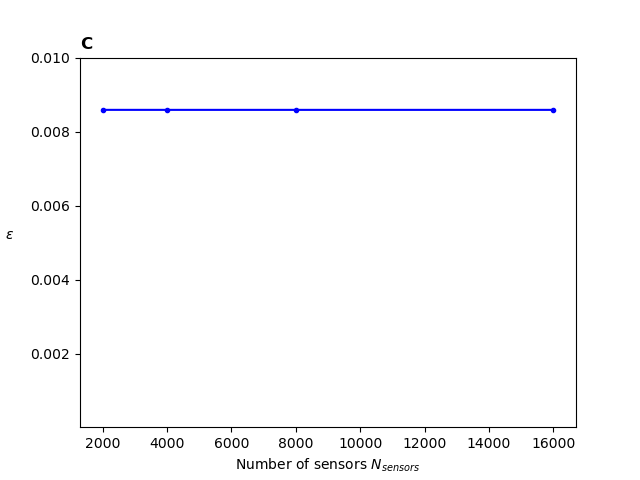

In [34]:
meshDensitySpace = np.array([2000, 4000, 8000, 16000]) #np.linspace(50, 500, 9)
# meshDensitySpace = np.array([200]) #np.linspace(50, 500, 9)
sigmaSpace = np.array([0.0025])  # np.logspace(-2, -1, 10) 
nSamplesSpace = np.array([2000]) #np.array([100, 200, 300, 400, 500, 600]) # np.linspace(50, 200, 16, dtype = 'I') 
rankSpace = np.array([100]) #np.linspace(5, 50, 46, dtype = 'I') #np.array([20])

plt.figure()
plt.plot(meshDensitySpace, np.mean(errors4, axis = 0)[:,0,0,0],'b.-')
plt.xlabel('Number of sensors $N_{sensors}$')
plt.ylabel('$\epsilon$', rotation='horizontal', labelpad=15)
plt.ylim([1e-5,1e-2])
plt.title('C',loc ='left', weight = 'bold', size = 12)